Importar librerias requeridas

In [1]:
import ee 
import geemap
import json
import os
import pandas as pd
import matplotlib.pyplot as plt


Autenticación con GEE y extracción de zona de estudio

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-rimartinezs')

In [3]:
with open(os.path.join(os.getcwd(), '..', 'data', 'Voronoi_Poligons_Usme.geojson')) as geojson:
    data = json.load(geojson)

zona_estudio = ee.FeatureCollection(data)

Calculo del NDVI

In [4]:
# Colección Landsat 8
l8Col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(zona_estudio) \
    .filterDate('2023-01-01', '2023-12-31')

# Recortar imágenes
def recortar(img):
    return img.clip(zona_estudio)
aoi_L8col = l8Col.map(recortar)

# Rescalar imágenes
escala = 0.0000275
inter = -0.2
def rescalar(img):
    bands = img.select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'])
    scaled = bands.multiply(escala).add(inter)
    return scaled.copyProperties(img, img.propertyNames())
aoi_L8_sr = aoi_L8col.map(rescalar)

# Calcular NDVI
def calcNDVI(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return image.addBands(ndvi).copyProperties(image, image.propertyNames())
l8Ndvi = aoi_L8_sr.map(calcNDVI)

#Imagen con menos nubes
un_Ndvi = l8Ndvi.sort('CLOUD_COVER').first()

ndvi_palette = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
                '74A901', '66A000', '529400', '3E8601', '207401', '056201',
                '004C00', '023B01', '012E01', '011D01', '011301']

# Seleccionar solo la banda NDVI
NDVIcol = l8Ndvi.select('NDVI')

#Promedio de NDVI por fecha y poligono 
def extraer_promedios(img):
    stats = img.reduceRegions(
        collection=zona_estudio,
        reducer=ee.Reducer.mean(),
        scale=30
    )
    stats = stats.map(lambda f: f.set('system:time_start', img.get('system:time_start')))
    return stats

ndvi_stats = NDVIcol.map(extraer_promedios).flatten()


# Convertir a lista
features = ndvi_stats.getInfo()['features']

# Procesar a DataFrame
rows = []
for f in features:
    props = f['properties']
    date = ee.Date(props['system:time_start']).format('YYYY-MM-dd').getInfo()
    rows.append({
        'id': props.get('rand_point_id'), 
        'date': date,
        'NDVI_mean': props.get('mean')
    })

df = pd.DataFrame(rows)
df['date'] = pd.to_datetime(df['date'])


Grafico del NDVI

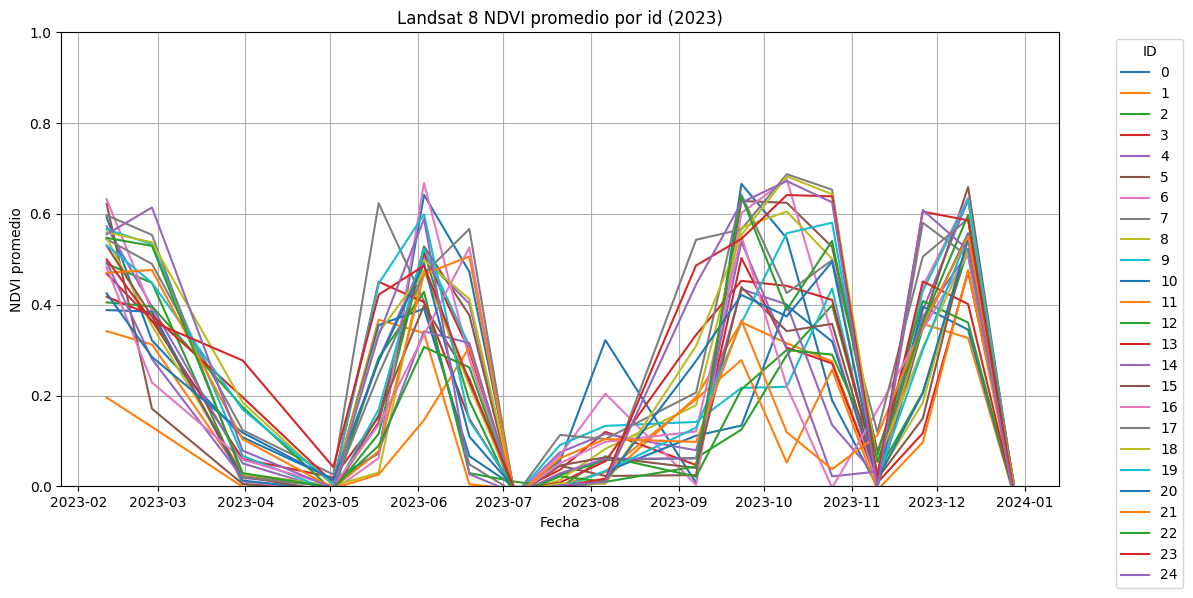

In [5]:
plt.figure(figsize=(12,6))
for key, grp in df.groupby('id'):
    plt.plot(grp['date'], grp['NDVI_mean'], label=str(key))
plt.title('Landsat 8 NDVI promedio por id (2023)')
plt.xlabel('Fecha')
plt.ylabel('NDVI promedio')
plt.ylim(0,1)
plt.legend(title='ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



Mapa del NDVI

In [6]:
Map = geemap.Map()
Map.centerObject(zona_estudio, 10)
Map.addLayer(zona_estudio, {}, 'Localidad de Usme')
Map.addLayer(un_Ndvi.select('NDVI'), {'min': 0, 'max': 1, 'palette': ndvi_palette}, 'NDVI')
Map 

Map(center=[4.390019031052541, -74.14281202673838], controls=(WidgetControl(options=['position', 'transparent_…